In [1]:
import sys
sys.path.append('../')

import thermonets as tn
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
from nrlmsise00 import msise_flat
import cartopy.crs as ccrs

### 1 - Load the model

In [2]:

# Here we create the model, which must be identical to the one loaded
model = tn.ffnn(input_dim=10,
                        hidden_layer_dims=[32, 32],
                        output_dim=12,
                        mid_activation=torch.nn.Tanh(),
                        last_activation=torch.nn.Tanh())
model_path = "../models/nrlmsise00_model_10_32_32_3.84.pyt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### 2 - Load the dataset

In [3]:

# Here we the db the model was trained upon.
#note that columns can be (len 16):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'wind zonal [m/s]', 'wind meridional [m/s]', 'density [kg/m^3]'
#or (len 14):
#'day', 'month', 'year', 'hour', 'minute', 'second', 'microsecond', 'alt [km]', 'lat [deg]', 'lon [deg]', 'f107A', 'f107', 'ap', 'density [kg/m^3]'
db=np.loadtxt('../dbs/nrlmsise00_db.txt',delimiter=',',skiprows=1)
np.random.shuffle(db)

with open('../global_fits/global_fit_nrlmsise00_180.0-1000.0-4.txt','rb') as f:
    best_global_fit=torch.from_numpy(pickle.load(f))
    
print(f'Shape of database is: {db.shape}')
print(f"Best fit has length: {len(best_global_fit)}")

Shape of database is: (999700, 16)
Best fit has length: 12


### 3 - Extract from the dataset all attributes
These include the quantities to be fed to the network as well as some auxiliary ones that are necessary to compute $\rho$

In [4]:
# Renames some of the db content with readable names
days=db[:,0]
months=db[:,1]
years=db[:,2]
hours=db[:,3]
minutes=db[:,4]
seconds=db[:,5]
microseconds=db[:,6]
alt=db[:,7]
# Geodetic longitude and latitude are converted in radians:
lat=np.deg2rad(db[:,8])
lon=np.deg2rad(db[:,9])
# Space weather indices:
f107a=db[:,10]
f107=db[:,11]
ap=db[:,12]
# Atmospheric density as well:
target_density=db[:,-1]

# We need to extract from the db also the doy (Day of Year) and the sid (seconds in day)
seconds_in_day=hours*3600+minutes*60+seconds+microseconds/1e6
print('seconds in day min and max:')
print(seconds_in_day.min(), seconds_in_day.max())
doys=np.zeros(db.shape[0])
for i in range(len(db)):
    #date is a string, so I first convert it to datetime:
    date_=datetime.datetime(year=int(years[i]), 
                            month=int(months[i]), 
                            day=int(days[i]),
                            hour=int(hours[i]),
                            minute=int(minutes[i]),
                            second=int(seconds[i]),
                            microsecond=int(microseconds[i]))
    doys[i]=date_.timetuple().tm_yday
print('day of the year min and max:')
print(doys.min(), doys.max())

seconds in day min and max:
2.616111 86393.877056
day of the year min and max:
1.0 365.0


In [5]:
db_processed=np.zeros((db.shape[0],13))
db_processed[:,0]=np.sin(lon)
db_processed[:,1]=np.cos(lon)
db_processed[:,2]=np.sin(lat)
db_processed[:,3]=np.sin(2*np.pi*seconds_in_day/86400.)
db_processed[:,4]=np.cos(2*np.pi*seconds_in_day/86400.)
db_processed[:,5]=np.sin(2*np.pi*doys/365.25)
db_processed[:,6]=np.cos(2*np.pi*doys/365.25)
db_processed[:,7]=tn.normalize_min_max(f107, 60., 266.)
db_processed[:,8]=tn.normalize_min_max(f107a, 60., 266.)
db_processed[:,9]=tn.normalize_min_max(ap, 0., 110.)
db_processed[:,10]=tn.normalize_min_max(alt, 170., 1010.)

#Add the non-normalized density & altitude columns (useful to extract during training):
db_processed[:,11]= alt
db_processed[:,12]= target_density

# Cross check that the max is <=1 and the min is >=-1
print(f"maximum and minimum of all the normalized data: {db_processed[:,7:11].max()}, {db_processed[:,7:11].min()}")
print(f"maximum and minimum of target density: {target_density.max()}, {target_density.min()}")

maximum and minimum of all the normalized data: 0.9761904761904763, -1.0
maximum and minimum of target density: 7.633109879889049e-10, 1.9555877118421126e-16


### 4 - Plots of the errors using the db entries

In [6]:
# We move the db into a torch array
db_processed_torch = torch.tensor(db_processed, dtype=torch.float32)
# Compute the parameters of the exponentials as params_i = params_i0 (1 + NNout_i)
delta_params = model(db_processed_torch[:,:-3])
params = best_global_fit*(1+delta_params)
# Compute the inference of the model over the entire dataset
predicted = tn.rho_approximation(db_processed_torch[:,-2], params, backend="torch")
true = db_processed_torch[:,-1]
predicted_global_fit=tn.rho_approximation(h=db_processed_torch[:,-2],params=best_global_fit,backend='torch')

In [7]:
rel_err = ((predicted - true) / true).detach() * 100
rel_err_global_fit = ((predicted_global_fit - true) / true).detach() * 100

print("Mean MAPE from NN model: ", torch.mean(torch.abs(rel_err)).item())
print("Mean MAPE from Global Fit model: ", torch.mean(torch.abs(rel_err_global_fit)).item())

Mean MAPE from NN model:  4.069037914276123
Mean MAPE from Global Fit model:  58.87457275390625


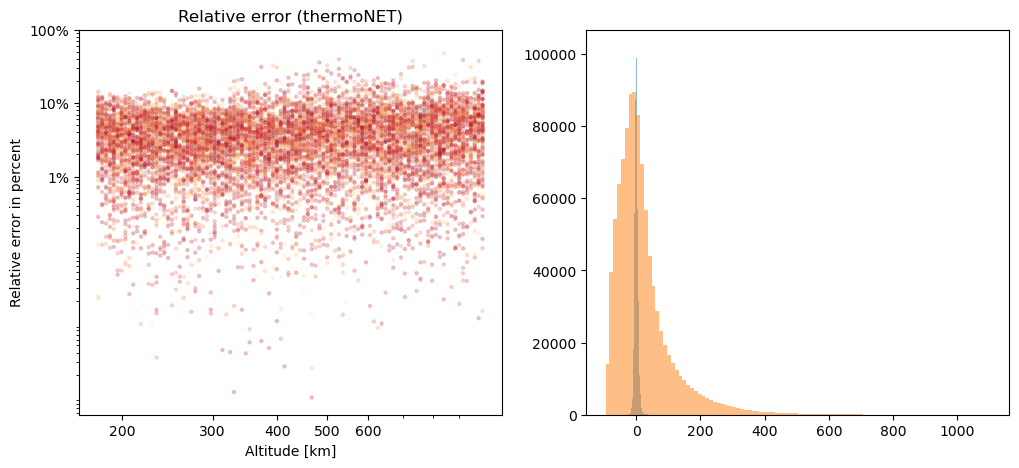

In [8]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
cm = plt.colormaps['RdYlBu']

rel_err = ((predicted - true) / true).detach() * 100

c = (db_processed_torch[::99,7]+1)/2
sc = ax[0].scatter(db_processed_torch[::99, 11], torch.abs(rel_err[::99]), alpha=0.2, c=c, s=5, cmap=cm)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_yticks([1, 10, 100], ["1%", "10%", "100%"])
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[0].set_title("Relative error (thermoNET)")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Relative error in percent")


#
ax[1].hist(rel_err, bins = 100, density=False, alpha=0.5);
ax[1].hist(rel_err_global_fit, bins = 100, density=False, alpha=0.5);

### 5 - Global thermospheric map

In [9]:
# We first establish the longitude latitude grid, by randomly picking points on a sphere:
n_grid=400
u,v=np.array(list(np.random.uniform(low=0,high=1,size=(n_grid,)))), np.array(list(np.random.uniform(low=0,high=1,size=(n_grid,))))
longitude,latitude=np.sort(2*np.pi*u), np.sort(np.arccos(2*v-1)-np.pi/2)#we sort them for plotting reasons
lonlat_grid=np.stack([*np.meshgrid(longitude,latitude)],axis=2).reshape(-1,2) #we generate the matrix of latitude longitude points

#we set a fixed altitude:
alt = 320.*torch.ones((len(lonlat_grid),))
# We then pick a date, and extract the day of the year, the seconds in day and the corresponding space weather quantities:
# Note: for each input I need to construct an array of the same length of lonlat_grid, for preparing the NN inference
date = datetime.datetime(2018, 6, 22, 1, 13, 35)
doys = date.timetuple().tm_yday * np.ones((len(lonlat_grid),))
seconds_in_day = (date.hour*3600+date.minute*60+date.second+date.microsecond/1e6) * np.ones((len(lonlat_grid),))
ap,f107,f107a = tn.get_nrlmsise00_spaceweather_indices([date] * len(lonlat_grid))

#we extract the target density (running NRLMSISE-00):
true = msise_flat(time=date, 
                          alt=alt, 
                          lon=np.rad2deg(lonlat_grid[:,0]), 
                          lat=np.rad2deg(lonlat_grid[:,1]), 
                          f107a=f107a, 
                          f107=f107, 
                          ap=ap)[:,5]*1e3

# we now prepare the normalized input data for the neural net:
db_processed=np.zeros((len(lonlat_grid),13))
db_processed[:,0]=np.sin(lonlat_grid[:,0])
db_processed[:,1]=np.cos(lonlat_grid[:,0])
db_processed[:,2]=np.sin(lonlat_grid[:,1])
db_processed[:,3]=np.sin(2*np.pi*seconds_in_day/86400.)
db_processed[:,4]=np.cos(2*np.pi*seconds_in_day/86400.)
db_processed[:,5]=np.sin(2*np.pi*doys/365.25)
db_processed[:,6]=np.cos(2*np.pi*doys/365.25)
db_processed[:,7]=tn.normalize_min_max(f107, 60., 266.)
db_processed[:,8]=tn.normalize_min_max(f107a, 60., 266.)
db_processed[:,9]=tn.normalize_min_max(ap, 0., 110.)
db_processed[:,10]=tn.normalize_min_max(alt, 170., 1010.)

#Add the non-normalized density & altitude columns:
db_processed[:,11]= alt
db_processed[:,12]= true
db_processed_torch = torch.tensor(db_processed, dtype=torch.float32)

#NN inference:
delta_params = model(db_processed_torch[:,:-3])
params = best_global_fit*(1+delta_params)
# Compute the inference of the model over the entire dataset
predicted = tn.rho_approximation(db_processed_torch[:,-2], 
                                 params,
                                 backend="torch")

Average absolute relative percentage error on globe map: 3.430970882480943 %


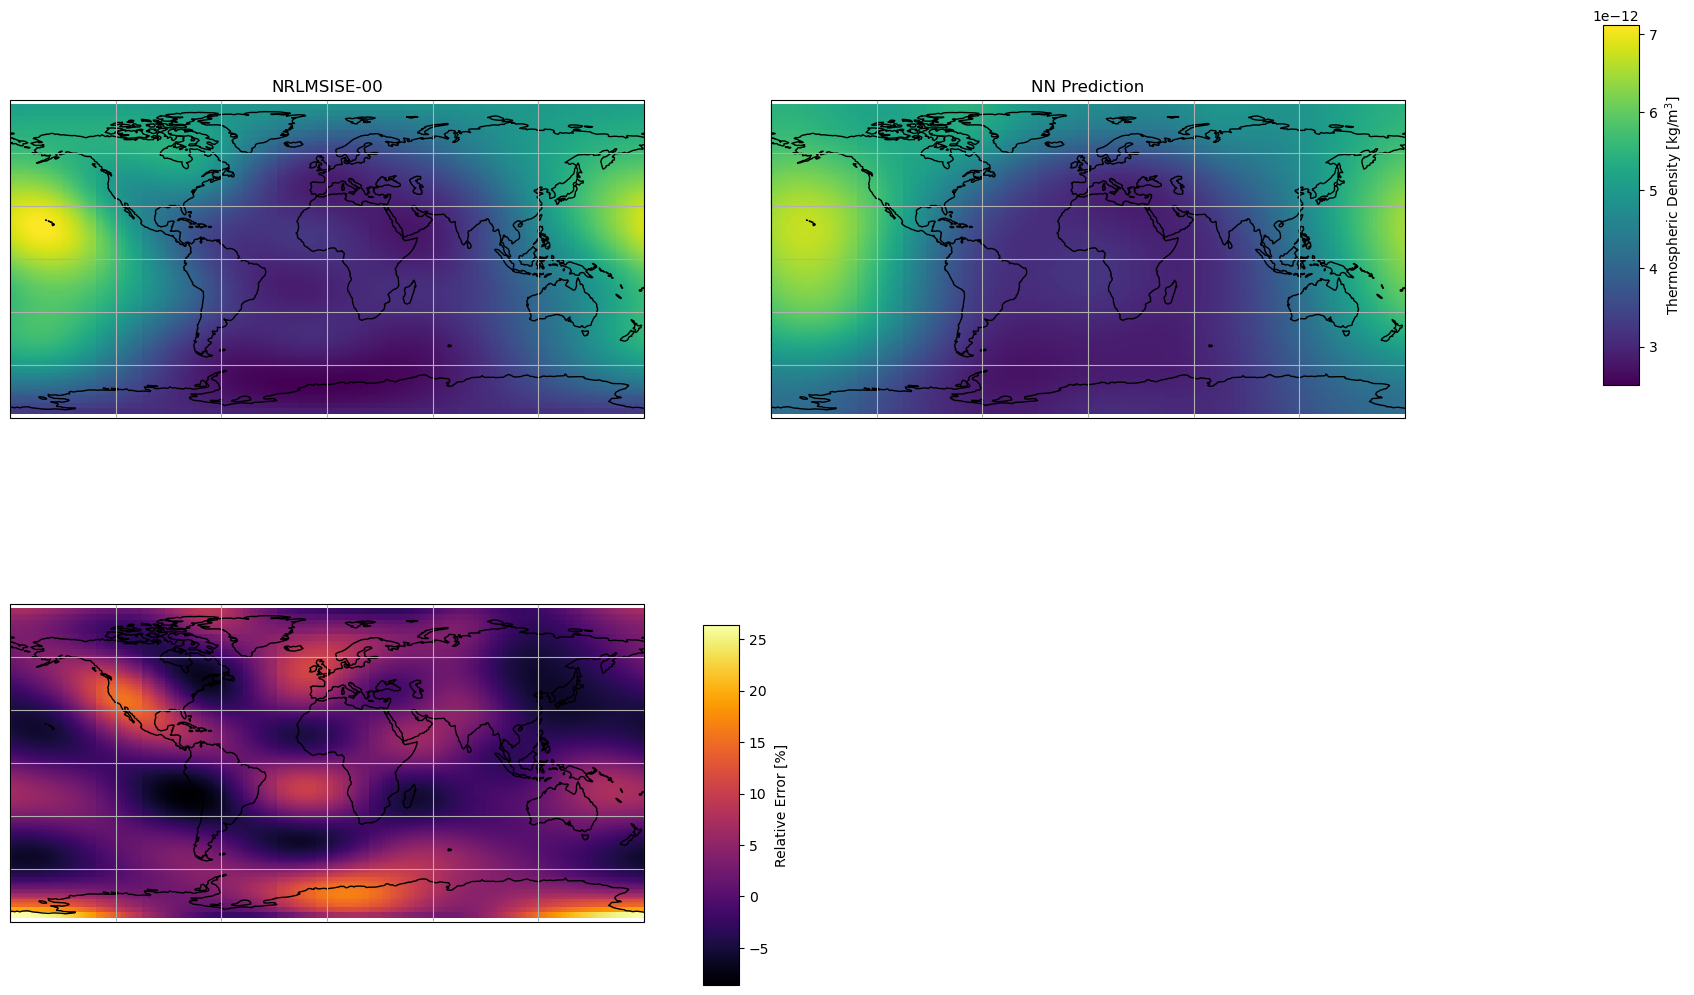

In [10]:
#we setup the longitude x latitude grid, and compute the relative error (in %)
lon_grid=np.rad2deg(lonlat_grid[:,0].reshape((n_grid,n_grid)))
lat_grid=np.rad2deg(lonlat_grid[:,1].reshape((n_grid,n_grid)))
rel_err = ((predicted.detach().numpy() - true) / true) * 100
#we print to scree the mean absolute percentage error on the globe map:
print(f'Average absolute relative percentage error on globe map: {abs(rel_err).mean()} %')
#we now store the minimum and maximum density values (between target & prediction), for plotting purposes:
vmin=min([true.min(), predicted.min().item()])
vmax=max([true.max(), predicted.max().item()])

#we now create a figure with a globe projection on top:
fig, ax = plt.subplots(figsize=(18, 12), nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
#we flatten the axis and remove the last figure
ax=ax.ravel()
ax[-1].axis('off')

#we plot NRLMSISE-00 on the first figure:
ax[0].pcolormesh(lon_grid, 
                        lat_grid, 
                        true.reshape((n_grid,n_grid)), transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax)
ax[0].set_global()
ax[0].coastlines()
ax[0].gridlines()
ax[0].set_title('NRLMSISE-00')

#the NN prediction on the second:
im2 = ax[1].pcolormesh(lon_grid, 
                        lat_grid, 
                        predicted.detach().numpy().reshape((n_grid,n_grid)), 
                        transform=ccrs.PlateCarree(),
                        vmin=vmin,
                        vmax=vmax)
ax[1].set_global()
ax[1].coastlines()
ax[1].gridlines()
ax[1].set_title('NN Prediction')
#we add a shared colorbar for the first two figures:
cax1 = fig.add_axes([1.01, 0.6, 0.02, 0.3])  # [left, bottom, width, height]
cbar1 = plt.colorbar(im2, 
                     orientation='vertical', 
                     fraction=0.035,
                     cax=cax1)
cbar1.set_label('Thermospheric Density [kg/m$^3$]')

#we finally plot the relative error in the second row
im3 = ax[2].pcolormesh(lon_grid, 
                        lat_grid, 
                        rel_err.reshape((n_grid,n_grid)), 
                        transform=ccrs.PlateCarree(),
                        cmap='inferno')
ax[2].set_global()
ax[2].coastlines()
ax[2].gridlines()
#and we add the colorbar for that:
cax2 = fig.add_axes([0.51, 0.1, 0.02, 0.3])  # [left, bottom, width, height]
cbar1 = plt.colorbar(im3, 
                     orientation='vertical', 
                     fraction=0.035,
                     cax=cax2)
cbar1.set_label('Relative Error [%]')
